# End-to-end machine learning project
This notebook is a simplified version of the intro ML project presented by Aurelion Geron in pages 37-85.  
Original source: https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb

#### start with importing our Python libraries

In [95]:
# common imports
from pathlib import Path
import os
import numpy as np
import pandas as pd

# sci-kit learn is our one-stop shop for machine learning!
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [96]:
sklearn.__version__

'1.0.2'

## Exploratory Data Analysis

In [97]:
# read in the dataset
filepath = Path.joinpath(Path.cwd(), 'data', 'housing.csv')
housing = pd.read_csv(filepath)
housing.sample(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


Decide what is our variable of interest (this is the item we want to predict, aka the Dependent Variable, labels, or target)

In [98]:
housing['median_house_value'].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

#### What is the story of one row?
"In this chapter we chose the California Housing Prices dataset from the StatLib repository2 (see Figure 2-1). This dataset was based on data from the 1990 California census. It is not exactly recent (you could still afford a nice house in the Bay Area at the time), but it has many qualities for learning, so we will pretend it is recent data. We also added a categorical attribute and removed a few features for teaching purposes." 

"Each row represents one district. There are 10 attributes (you can see the first 6 in the screenshot): longitude, latitude, housing_median_age, total_rooms, total_bed rooms, population, households, median_income, median_house_value, and ocean_proximity."  
-- Geron, pg. 38

In [99]:
housing['latitude'].describe()

count    20640.000000
mean        35.631861
std          2.135952
min         32.540000
25%         33.930000
50%         34.260000
75%         37.710000
max         41.950000
Name: latitude, dtype: float64

In [100]:
housing['longitude'].describe()

count    20640.000000
mean      -119.569704
std          2.003532
min       -124.350000
25%       -121.800000
50%       -118.490000
75%       -118.010000
max       -114.310000
Name: longitude, dtype: float64

In [101]:
housing['median_income'].describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

In [102]:
housing['housing_median_age'].describe()

count    20640.000000
mean        28.639486
std         12.585558
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64

In [103]:
housing['total_rooms'].describe()

count    20640.000000
mean      2635.763081
std       2181.615252
min          2.000000
25%       1447.750000
50%       2127.000000
75%       3148.000000
max      39320.000000
Name: total_rooms, dtype: float64

In [104]:
housing['population'].describe()

count    20640.000000
mean      1425.476744
std       1132.462122
min          3.000000
25%        787.000000
50%       1166.000000
75%       1725.000000
max      35682.000000
Name: population, dtype: float64

In [105]:
housing['households'].describe()

count    20640.000000
mean       499.539680
std        382.329753
min          1.000000
25%        280.000000
50%        409.000000
75%        605.000000
max       6082.000000
Name: households, dtype: float64

## Feature Engineering

In [106]:
# Create income categories
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [107]:
housing["income_cat"].value_counts().sort_index(ascending=True)

1     822
2    6581
3    7236
4    3639
5    2362
Name: income_cat, dtype: int64

In [108]:
# Create some additional variables
housing["rooms_per_hhold"] = housing["total_rooms"]/housing["households"]
housing["pop_per_household"]=housing["population"]/housing["households"]

In [109]:
housing["rooms_per_hhold"].describe()

count    20640.000000
mean         5.429000
std          2.474173
min          0.846154
25%          4.440716
50%          5.229129
75%          6.052381
max        141.909091
Name: rooms_per_hhold, dtype: float64

In [110]:
housing["pop_per_household"].describe()

count    20640.000000
mean         3.070655
std         10.386050
min          0.692308
25%          2.429741
50%          2.818116
75%          3.282261
max       1243.333333
Name: pop_per_household, dtype: float64

#### One-hot Encoding
"This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold)." - Geron, pg. 70

In [111]:
housing['ocean_proximity'].value_counts().sort_values(ascending=False)

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [112]:
# Create dummy variables for ocean proximity
# Note: this is also called "one-hot encoding"
housing=pd.get_dummies(housing, columns = ['ocean_proximity'], prefix='', prefix_sep='')

In [113]:
# what are the variables?
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'income_cat', 'rooms_per_hhold',
       'pop_per_household', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN'],
      dtype='object')

In [114]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,rooms_per_hhold,pop_per_household,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,5,6.984127,2.555556,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,5,6.238137,2.109842,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,5,8.288136,2.802260,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,4,5.817352,2.547945,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3,6.281853,2.181467,0,0,0,1,0


## Prepare the data for Machine Learning algorithms

#### Get rid of missing data
Geron actually shows multiple options here (such as imputing the median) but we're just going to drop all rows with missing data.

In [115]:
# sklearn cannot handle missing data. we're just doing to drop it
print(len(housing))
print(housing.isnull().sum())
housing.dropna(axis=1, inplace=True)
print(len(housing))

20640
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
income_cat              0
rooms_per_hhold         0
pop_per_household       0
<1H OCEAN               0
INLAND                  0
ISLAND                  0
NEAR BAY                0
NEAR OCEAN              0
dtype: int64
20640


## Train-test split

"The only way to know how well a model will generalize to new cases is to actually try it out on new cases. One way to do that is to put your model in production and moni‐ tor how well it performs. This works well, but if your model is horribly bad, your users will complain—not the best idea.
A better option is to split your data into two sets: the training set and the test set. As these names imply, you train your model using the training set, and you test it using the test set. The error rate on new cases is called the generalization error (or out-of- sample error), and by evaluating your model on the test set, you get an estimate of this error. This value tells you how well your model will perform on instances it has never seen before."  -- Geron, pg. 31

In [116]:
# First, split your data into features (X) and labels (y).
y = housing["median_house_value"].copy()
# We drop one of the 'ocean_proximity' categories so that the coefficients will be interpretable
X = housing.drop(["median_house_value",'<1H OCEAN'], axis=1)
# Compare their shapes.
print(y.shape)
print(X.shape)

(20640,)
(20640, 14)


In [117]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income', 'income_cat',
       'rooms_per_hhold', 'pop_per_household', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN'],
      dtype='object')

In [118]:
# Now, split both X and y data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                       test_size=0.2, 
                                       random_state=42)

In [119]:
# Compare the shapes to confirm this did what you wanted.
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(16512, 14)
(16512,)
(4128, 14)
(4128,)


### Feature scaling
"One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don’t perform well when the input numerical attributes have very different scales. This is the case for the hous‐ ing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.
There are two common ways to get all attributes to have the same scale: min-max scaling (i.e., normalization) and standardization."  -- Geron, pg. 72

"Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algo‐ rithms (e.g., neural networks often expect an input value ranging from 0 to 1). However, standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called StandardScaler for standardization."  -- Geron, pg. 73

In [120]:
# What are the numeric variables in my dataset?
X_train.describe().columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income', 'rooms_per_hhold',
       'pop_per_household', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype='object')

Note: Geron includes `median_house_value` in his scaling, but I do not. It's not actually necessary to scale your dependent variable (i.e., your target) and leaving it in the original metric makes the results a lot easier to interpret.


### One type of feature scaling: Standardization
take a look at pages 72-73 in the Geron Aurelion book.
One of the most important transformations you need to apply to your data is feature scaling. With few exceptions, Machine Learning algorithms don't perform well when the input numerical attributes have very different scales.  
https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well

Note: The following code only works because we dropped missing data earlier. This is pretty common in `sklearn` -- either drop or impute missing values at the start of your analysis!

In [121]:
# "Instantiate" the scaler (create an instance of the sklearn class)
std_scaler = StandardScaler()


In [122]:
# 'Fit' the scaler to our X_train data
std_scaler = std_scaler.fit(X_train.values)
std_scaler

StandardScaler()

In [123]:
# Use the scaler to transform the dataset
X_train_scaled = std_scaler.transform(X_train.values)
X_train_scaled[0]

array([ 1.27258656, -1.3728112 ,  0.34849025,  0.22256942,  0.76827628,
        0.32290591, -0.326196  , -0.01226031, -0.17491646,  0.05137609,
       -0.68057418, -0.01556621, -0.35564565,  2.62975816])

In [124]:
# Use the scaler to transform the dataset
X_test_scaled = std_scaler.transform(X_test.values)
X_test_scaled[0]

array([ 0.28534728,  0.1951    , -0.28632369, -0.52286157, -0.03030109,
       -0.37008673, -1.15508475, -0.95825178, -0.52068576,  0.06740798,
        1.46934754, -0.01556621, -0.35564565, -0.3802631 ])

## Select and train a model

In [125]:
# Create a local instance of the sklearn class
lin_reg = LinearRegression(fit_intercept=True)
lin_reg

LinearRegression()

In [126]:
# Fit your instance to the training dataset
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [127]:
# Check the intercept and coefficients
print(lin_reg.intercept_)
print(lin_reg.coef_)

207194.69373788772
[-53324.43561748 -55050.39411163  14100.68748397 -10335.67849807
 -47191.08662137  61902.56347524  62180.85252837  10016.97557007
   7036.51646492   1205.7015154  -18644.29768629   2293.29683112
  -1274.33774084   1305.65722059]


## Examine the feature importances

In [128]:
# 'Attributes' is another name for our list of features (aka predictors, independent variables)
attributes=X_test.columns
print(attributes)
# 'Feature importances' is another name for our coefficients (ie., the impace of each feature on the outcome or DV)
feature_importances=lin_reg.coef_
print(feature_importances)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income', 'income_cat',
       'rooms_per_hhold', 'pop_per_household', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN'],
      dtype='object')
[-53324.43561748 -55050.39411163  14100.68748397 -10335.67849807
 -47191.08662137  61902.56347524  62180.85252837  10016.97557007
   7036.51646492   1205.7015154  -18644.29768629   2293.29683112
  -1274.33774084   1305.65722059]


In [129]:
# obviously, these 2 things will have the same length
print(len(feature_importances))
print(len(attributes))

14
14


In [130]:
[int(x) for x in list(feature_importances)]

[-53324,
 -55050,
 14100,
 -10335,
 -47191,
 61902,
 62180,
 10016,
 7036,
 1205,
 -18644,
 2293,
 -1274,
 1305]

In [131]:
# let's take a look at the results
feature_imp = pd.DataFrame(list(zip(attributes, feature_importances)), columns=['features', 'coeffs'])
feature_imp=feature_imp.set_index('features')
feature_imp=feature_imp.sort_values('coeffs')
feature_imp

,coeffs
features,
latitude,-55050.394112
longitude,-53324.435617
population,-47191.086621
INLAND,-18644.297686
total_rooms,-10335.678498
NEAR BAY,-1274.337741
pop_per_household,1205.701515
NEAR OCEAN,1305.657221
ISLAND,2293.296831


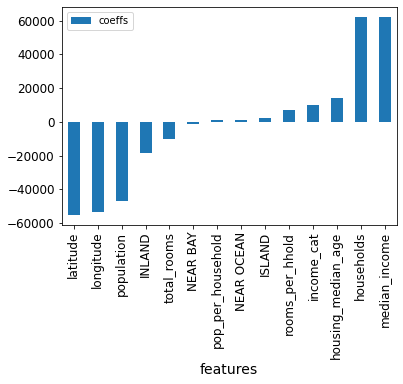

In [132]:
# plot that as a bar chart
feature_imp.plot(kind='bar');

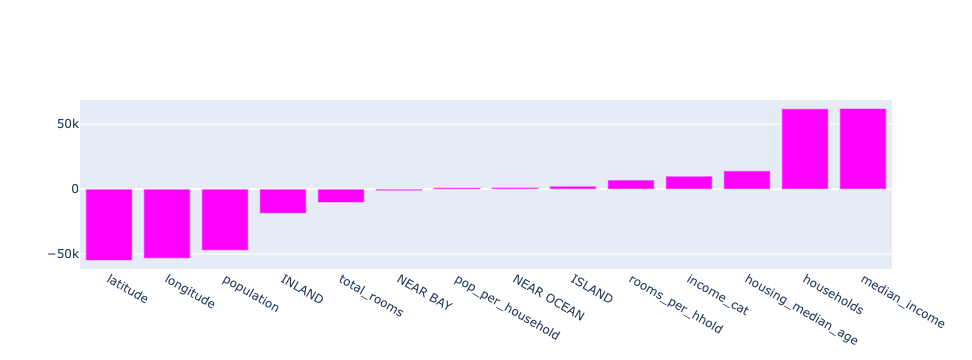

In [133]:
# with plotly
!pip install plotly
import plotly.graph_objects as go
data = go.Bar(x=list(feature_imp.index), y=feature_imp['coeffs'], marker_color="magenta")
coefs = go.Figure([data])
coefs

### Predict for a single value

In [134]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income', 'income_cat',
       'rooms_per_hhold', 'pop_per_household', 'INLAND', 'ISLAND', 'NEAR BAY',
       'NEAR OCEAN'],
      dtype='object')

In [135]:
# Show variables for a single observation:
print(X_train.iloc[0])

longitude             -117.030000
latitude                32.710000
housing_median_age      33.000000
total_rooms           3126.000000
population            2300.000000
households             623.000000
median_income            3.259600
income_cat               3.000000
rooms_per_hhold          5.017657
pop_per_household        3.691814
INLAND                   0.000000
ISLAND                   0.000000
NEAR BAY                 0.000000
NEAR OCEAN               1.000000
Name: 14196, dtype: float64


In [136]:
# Show scaled variables for that single observation:
# Remember that we dropped the variable "<1H OCEAN"
print(X_train_scaled[0])

[ 1.27258656 -1.3728112   0.34849025  0.22256942  0.76827628  0.32290591
 -0.326196   -0.01226031 -0.17491646  0.05137609 -0.68057418 -0.01556621
 -0.35564565  2.62975816]


In [137]:
# Make a prediction on that:
lin_reg.predict([X_train_scaled[0]])

array([196220.07796421])

In [138]:
# Make up some fake data that's similar
fake = np.array([-122, 37, 40, 2000, 3000, 500, 3, 3, 6, 4, 0, 0, 1, 0]).reshape(1, -1)
fake

array([[-122,   37,   40, 2000, 3000,  500,    3,    3,    6,    4,    0,
           0,    1,    0]])

In [139]:
# Standardize using the trained scaler
std_fake = std_scaler.transform(fake)
std_fake

array([[-1.20548375e+00,  6.35051202e-01,  9.03952444e-01,
        -2.95231503e-01,  1.38391963e+00,  3.43382980e-05,
        -4.62523625e-01, -1.22603061e-02,  2.36570339e-01,
         7.79934457e-02, -6.80574180e-01, -1.55662057e-02,
         2.81178749e+00, -3.80263103e-01]])

In [140]:
# Try a prediction for that observation:
lin_reg.predict(std_fake)

array([168457.05166843])

## Make predictions on your testing dataset

In [141]:
# Make predictions on the testing dataset
y_preds = lin_reg.predict(X_test_scaled)

In [142]:
# Examine your predictions
y_preds

array([ 48646.36079914, 142586.97421779, 319088.42978437, ...,
       434697.81249877, 122516.33885779, 181666.30421855])

In [143]:
# How do the first five predictions compare to the first five actual values?
true_5=list(round(y_test[:5], 1))
pred_5=[round(x,1) for x in list(y_preds[:5])]
print('true values:', true_5)
print('predicted values:', pred_5)

true values: [47700.0, 45800.0, 500001.0, 218600.0, 278000.0]
predicted values: [48646.4, 142587.0, 319088.4, 276866.0, 266687.2]


In [144]:
# How do we intepret those results?
first_5=['district0', 'district1', 'district2', 'district3', 'distict4']
pd.DataFrame(list(zip(first_5, true_5, pred_5)), columns=['district', 'true', 'predicted'])

,district,true,predicted
0,district0,47700.0,48646.4
1,district1,45800.0,142587.0
2,district2,500001.0,319088.4
3,district3,218600.0,276866.0
4,distict4,278000.0,266687.2


## Evaluate your model

#### RMSE

In [145]:
# root mean squared error represents the average error (in $) of our model
rmse_ols = np.sqrt(metrics.mean_squared_error(y_test, y_preds))
rmse_ols = int(rmse_ols)
rmse_ols 

69479

In [146]:
# how does this compare to a coinflip (i.e., the mean of our training set)?
avg_val = round(y_train.mean(),2)
avg_val

207194.69

In [147]:
# If we used that as our predictor, then the average error (RMSE) of our model would be:
coinflip_preds=np.full((len(y_test), ), avg_val)
rmse_coinflip=np.sqrt(metrics.mean_squared_error(y_test, coinflip_preds))
rmse_coinflip=int(rmse_coinflip)
rmse_coinflip

114485

#### R-squared

In [148]:
# R-squared is the proportion of the variance in the DV that's explained by the model
r2_ols=metrics.r2_score(y_test, y_preds)
r2_ols=round(r2_ols, 2)
r2_ols

0.63

In [149]:
# how does this compare to a coinflip (i.e., the mean of our training set)?
r2_coinflip=metrics.r2_score(y_test, coinflip_preds)
r2_coinflip=round(r2_coinflip,2)
r2_coinflip

-0.0

#### Plot the evaluation comparison as a bar chart

In [150]:
# Compare OLS Linear Regression to the Baseline

evaluation_df = pd.DataFrame([['Baseline',rmse_coinflip, r2_coinflip], 
                              ['OLS Linear Regression', rmse_ols, r2_ols]], 
                             columns=['Model','RMSE','R-squared']
                            )
evaluation_df.set_index('Model', inplace=True)
evaluation_df

,RMSE,R-squared
Model,,
Baseline,114485,-0.00
OLS Linear Regression,69479,0.63


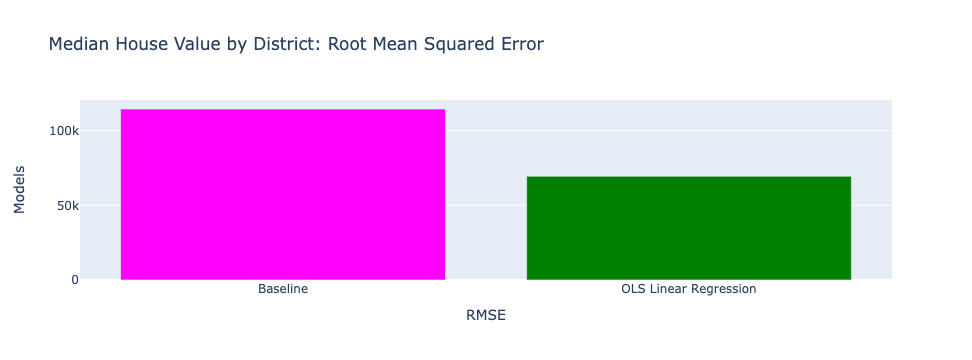

In [151]:
# Bar chart with plotly: RMSE
import plotly.graph_objects as go
trace = go.Bar(x=list(evaluation_df.index), y=evaluation_df['RMSE'], marker=dict(color=['magenta', 'green']))
layout = go.Layout(title = 'Median House Value by District: Root Mean Squared Error', # Graph title
    yaxis = dict(title = 'Models'), # x-axis label
    xaxis = dict(title = 'RMSE'), # y-axis label  
                  ) 

fig = go.Figure(data = [trace], layout=layout)
fig

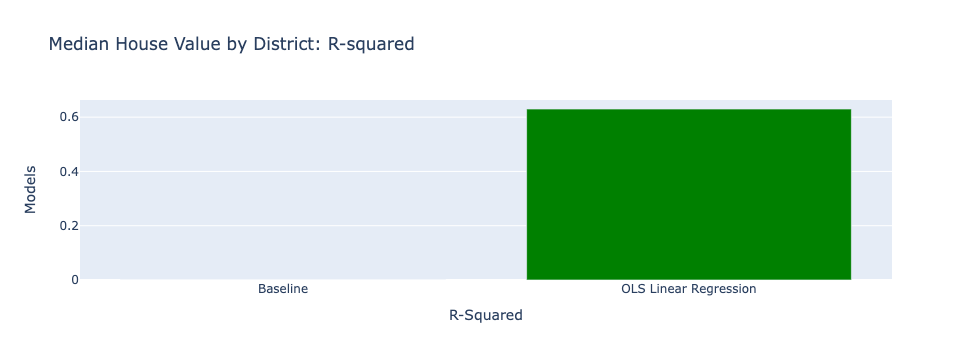

In [152]:
# Bar chart with plotly: RMSE
import plotly.graph_objects as go
trace = go.Bar(x=list(evaluation_df.index), y=evaluation_df['R-squared'], marker=dict(color=['magenta', 'green']))
layout = go.Layout(title = 'Median House Value by District: R-squared', # Graph title
    yaxis = dict(title = 'Models'), # x-axis label
    xaxis = dict(title = 'R-Squared'), # y-axis label  
                  ) 

fig = go.Figure(data = [trace], layout=layout)
fig

#### Evaluation as a scatterplot

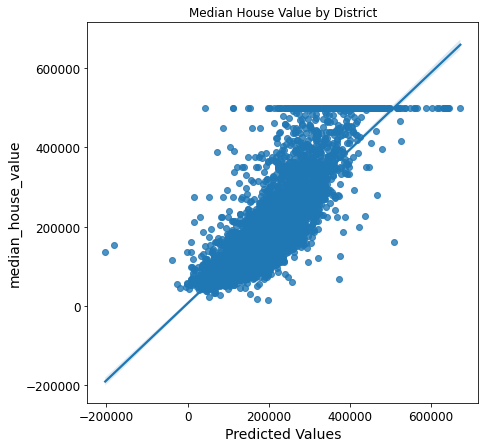

In [153]:
# Visualize our true vs. predicted values
import seaborn as sns
plt.figure(figsize=(7,7))
plt.title('Median House Value by District')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
fig=sns.regplot(x=y_preds, y=y_test)
plt.show(fig)

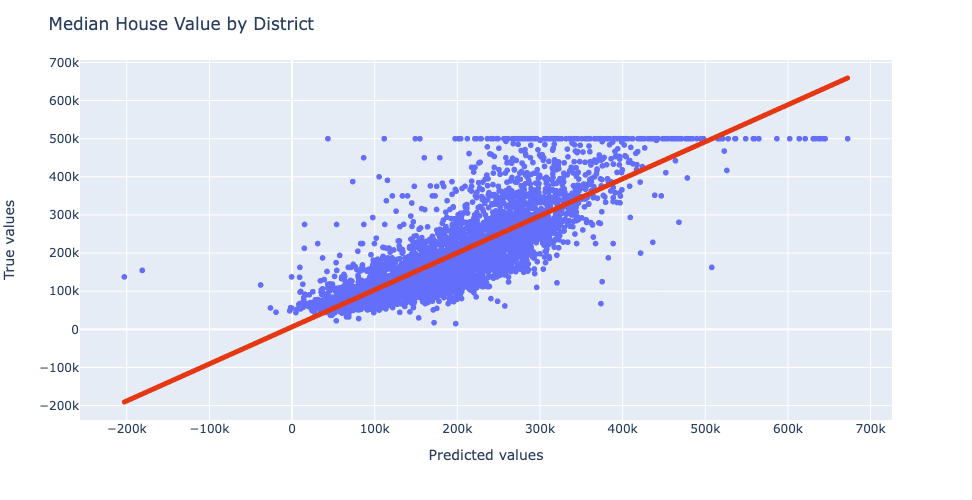

In [154]:
# same thing with plotly
!pip install statsmodels
import plotly.express as px
fig = px.scatter(y=y_test, x=y_preds, trendline="ols", width=500, height=500)
fig.update_layout(title = 'Median House Value by District', # Graph title
    yaxis = dict(title = 'True values'), # x-axis label
    xaxis = dict(title = 'Predicted values'), # y-axis label   
)
fig.update_traces(line_color='#E53712', line_width=5)
fig.show()

## Try out some other regression models

#### Ridge Regression

In [155]:
# Import the model
from sklearn import linear_model
# Create a local instance of the sklearn class
ridge_model = linear_model.Ridge(alpha=.5)
# Fit your instance to the training dataset
ridge_model.fit(X_train_scaled, y_train)
# Make predictions on the testing dataset
y_preds = ridge_model.predict(X_test_scaled)
# root mean squared error represents the average error (in $) of our model
ridge_rmse = int(np.sqrt(metrics.mean_squared_error(y_test, y_preds)))
# R-squared is the proportion of the variance in the DV that's explained by the model
ridge_r2=round(metrics.r2_score(y_test, y_preds),2)
print(ridge_rmse, ridge_r2)

69478 0.63


#### K-Nearest Neighbors Regression

In [156]:
# Import the model
from sklearn.neighbors import KNeighborsRegressor
# Create a local instance of the sklearn class
knn_model = KNeighborsRegressor(n_neighbors=8)
# Fit your instance to the training dataset
knn_model.fit(X_train_scaled, y_train)
# Make predictions on the testing dataset
y_preds = knn_model.predict(X_test_scaled)
# root mean squared error represents the average error (in $) of our model
knn_rmse = int(np.sqrt(metrics.mean_squared_error(y_test, y_preds)))
# R-squared is the proportion of the variance in the DV that's explained by the model
knn_r2=round(metrics.r2_score(y_test, y_preds),2)
print(knn_rmse, knn_r2)

61061 0.72


#### Decision Tree Regression

In [157]:
# Import the model
from sklearn.tree import DecisionTreeRegressor
# Create a local instance of the sklearn class
tree_model = DecisionTreeRegressor(max_depth=9)
# Fit your instance to the training dataset
tree_model.fit(X_train_scaled, y_train)
# Make predictions on the testing dataset
y_preds = tree_model.predict(X_test_scaled)
# root mean squared error represents the average error (in $) of our model
tree_rmse = int(np.sqrt(metrics.mean_squared_error(y_test, y_preds)))
# R-squared is the proportion of the variance in the DV that's explained by the model
tree_r2=round(metrics.r2_score(y_test, y_preds),2)
print(tree_rmse, tree_r2)

61408 0.71


#### Random Forest Regression

In [158]:
# Import the model
from sklearn.ensemble import RandomForestRegressor
# Create a local instance of the sklearn class
forest_model = RandomForestRegressor(max_depth=10, n_estimators=200)
# Fit your instance to the training dataset
forest_model.fit(X_train_scaled, y_train)
# Make predictions on the testing dataset
y_preds = forest_model.predict(X_test_scaled)
# root mean squared error represents the average error (in $) of our model
forest_rmse = int(np.sqrt(metrics.mean_squared_error(y_test, y_preds)))
# R-squared is the proportion of the variance in the DV that's explained by the model
forest_r2=round(metrics.r2_score(y_test, y_preds),2)
print(forest_rmse, forest_r2)

53270 0.78


#### Plot the evaluation comparison as a bar chart

In [159]:
# Compare OLS Linear Regression to the Baseline

evaluation_df2 = pd.DataFrame([['Baseline',rmse_coinflip, r2_coinflip], 
                              ['OLS Linear Regression', rmse_ols, r2_ols],
                              ['Ridge Regession', ridge_rmse, ridge_r2],
                              ['K-Nearest Neighbors Regression', knn_rmse, knn_r2],
                              ['Decision Tree Regression', tree_rmse, tree_r2],
                              ['Random Forest Regression', forest_rmse, forest_r2]], 
                             columns=['Model','RMSE','R-squared']
                            )
evaluation_df2.set_index('Model', inplace=True)
evaluation_df2

,RMSE,R-squared
Model,,
Baseline,114485,-0.00
OLS Linear Regression,69479,0.63
Ridge Regession,69478,0.63
K-Nearest Neighbors Regression,61061,0.72
Decision Tree Regression,61408,0.71
Random Forest Regression,53270,0.78


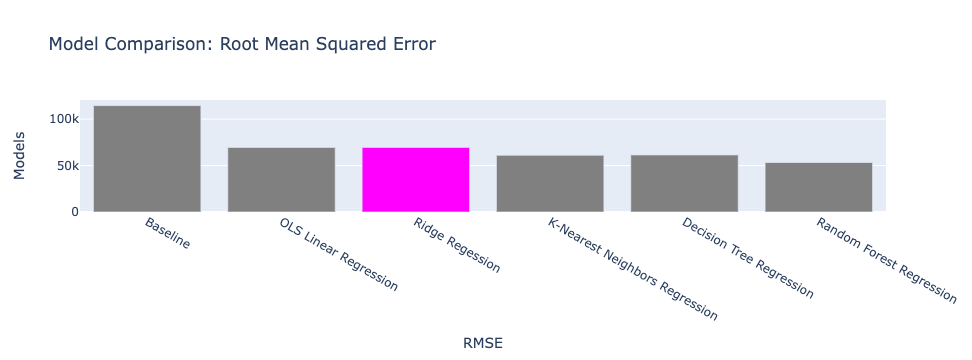

In [160]:
# Bar chart with plotly: RMSE
import plotly.graph_objects as go
trace = go.Bar(x=list(evaluation_df2.index), 
               y=evaluation_df2['RMSE'], 
               marker=dict(color=['gray', 'gray', 'magenta', 'gray', 'gray', 'gray']),
#                marker=dict(color=['#ebc83d','#badf55', '#35b1c9','#b06dad','#e96060', '#1e1d69']),
#               plot_bgcolor='rgb(10,10,10)'
              )
layout = go.Layout(title = 'Model Comparison: Root Mean Squared Error', # Graph title
    yaxis = dict(title = 'Models'), # x-axis label
    xaxis = dict(title = 'RMSE'), # y-axis label  
                  ) 

rmse_fig = go.Figure(data = [trace], layout=layout)
rmse_fig

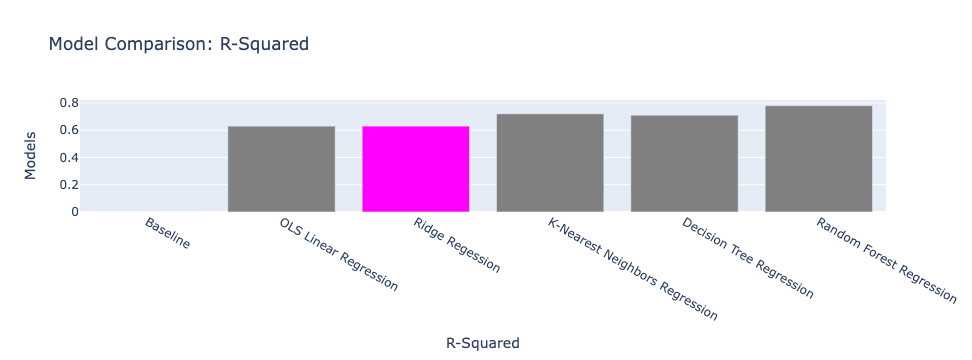

In [161]:
# Bar chart with plotly: R-Squared
import plotly.graph_objects as go
trace = go.Bar(x=list(evaluation_df2.index), 
               y=evaluation_df2['R-squared'], 
               marker=dict(color=['gray', 'gray', 'magenta', 'gray', 'gray', 'gray']),
#                marker=dict(color=['#ebc83d','#badf55', '#35b1c9','#b06dad','#e96060', '#1e1d69']),
#               plot_bgcolor='rgb(10,10,10)'
              )
layout = go.Layout(title = 'Model Comparison: R-Squared', # Graph title
    yaxis = dict(title = 'Models'), # x-axis label
    xaxis = dict(title = 'R-Squared'), # y-axis label  
                  ) 

r2_fig = go.Figure(data = [trace], layout=layout)
r2_fig

### Save all outputs for visualization in Dash app

In [162]:
import pickle

In [163]:
# Store the figures
with open('model_components/coefs_fig.pkl', 'wb') as handle:
    pickle.dump(coefs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [164]:
# Store the figures
with open('model_components/rmse_fig.pkl', 'wb') as handle:
    pickle.dump(rmse_fig, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [165]:
# Store the figures
with open('model_components/r2_fig.pkl', 'wb') as handle:
    pickle.dump(r2_fig, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [166]:
# Store the standard scaler
with open('model_components/std_scaler.pkl', 'wb') as handle:
    pickle.dump(std_scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [167]:
# Store regression model 
import pickle
with open('model_components/lin_reg.pkl', 'wb') as handle:
    pickle.dump(lin_reg, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [168]:
# Store Ridge regression model 
import pickle
with open('model_components/ridge_reg.pkl', 'wb') as handle:
    pickle.dump(ridge_model , handle, protocol=pickle.HIGHEST_PROTOCOL)

## Re-open those pickle files

In [169]:
with open('model_components/rmse_fig.pkl', 'rb') as f:
    reopen_fig1=pickle.load(f)

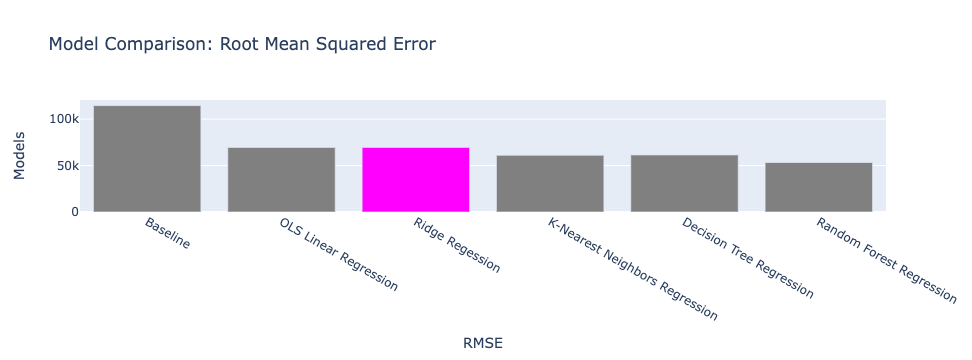

In [170]:
reopen_fig1